./slurm_scripts/submit.sh \
    scripts/run_shakespeare_pdhg_adamw.sh \
    param_configs/attn_pdhg_adamw_sweep.json \
    gpt_tiny_pdhg \
    12


./slurm_scripts/submit.sh \
    scripts/run_shakespeare_pdhg_adamw.sh \
    param_configs/attn_pdhg_adamw.json \
    gpt_small_pdhg \
    1

In [5]:
import os
import json
from glob import glob
import pandas as pd

BASE_DIR = "/mnt/home/tparshakova/Documents/GPT-opt/outputs/gpt-tiny/default/tiny_shakespeare/attn_pdhg_adamw"

def load_sweep_jsons(base_dir: str = BASE_DIR) -> pd.DataFrame:
    """Recursively load all JSON logger files from the PDHG sweep.

    Each record includes:
      - path: full path to the JSON file
      - lr: learning rate parsed from the directory name bs-4-lr-*-wd-*
      - wd: weight decay parsed from the directory name
      - max_norm_tr: parsed from filename pattern ...-maxnorm-<value>-<hash>.json, if present
      - final_train_loss: last value in logger.losses
      - min_val_loss: minimum of logger.val_losses (NaN if empty)
    """
    pattern = os.path.join(base_dir, "**", "*.json")
    files = sorted(glob(pattern, recursive=True))
    records = []

    for path in files:
        try:
            with open(path, "r") as f:
                d = json.load(f)
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
            continue

        losses = d.get("losses", [])
        val_losses = d.get("val_losses", [])
        if not losses:
            continue

        final_train_loss = losses[-1]
        min_val_loss = min(val_losses) if val_losses else float("nan")

        # Parse lr and wd from directory name: bs-4-lr-0.003-wd-0
        lr = None
        wd = None
        dir_name = os.path.basename(os.path.dirname(path))
        parts = dir_name.split("-")
        for i, p in enumerate(parts):
            if p == "lr" and i + 1 < len(parts):
                try:
                    lr = float(parts[i + 1])
                except ValueError:
                    pass
            if p == "wd" and i + 1 < len(parts):
                try:
                    wd = float(parts[i + 1])
                except ValueError:
                    pass

        # Parse max_norm_tr from filename: ...-maxnorm-0.001-<hash>.json
        max_norm_tr = None
        fname_parts = os.path.basename(path).split("-")
        for i, p in enumerate(fname_parts):
            if p == "maxnorm" and i + 1 < len(fname_parts):
                val_str = fname_parts[i + 1]
                # Strip extension if it somehow ended up attached
                val_str = val_str.replace(".json", "")
                try:
                    max_norm_tr = float(val_str)
                except ValueError:
                    pass

        records.append({
            "path": path,
            "lr": lr,
            "wd": wd,
            "max_norm_tr": max_norm_tr,
            "final_train_loss": final_train_loss,
            "min_val_loss": min_val_loss,
        })

    return pd.DataFrame(records)

# Example usage:
df = load_sweep_jsons()

In [6]:
df

,path,lr,wd,max_norm_tr,final_train_loss,min_val_loss
0,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.001,0.0,0.001,6.722084,6.778138
1,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.001,0.0,0.010,6.725578,6.782411
2,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.001,0.0,0.100,6.721237,6.756868
3,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.001,0.0,1.000,6.734032,6.782301
4,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.003,0.0,0.001,6.836926,6.893906
5,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.003,0.0,0.010,6.818512,6.882143
6,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.003,0.0,0.100,6.841347,6.885756
7,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.003,0.0,1.000,6.870560,6.915587
8,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.005,0.0,0.001,6.801392,6.886272
9,/mnt/home/tparshakova/Documents/GPT-opt/output...,0.005,0.0,0.010,6.776138,6.872283


Number of runs used for plots: 12


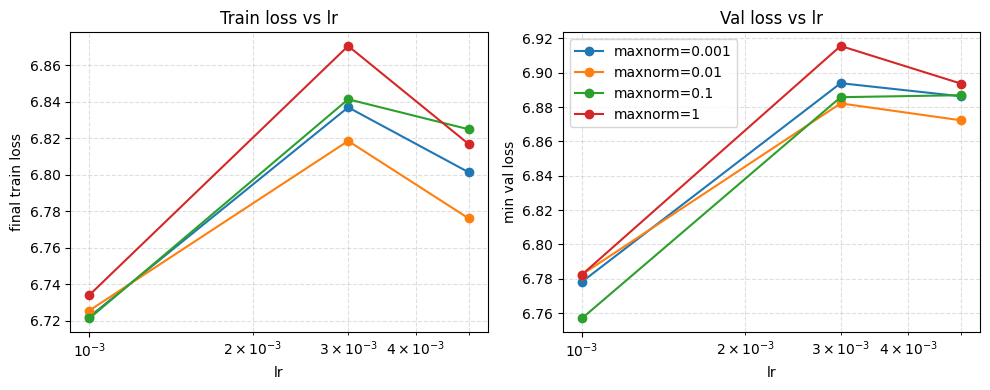

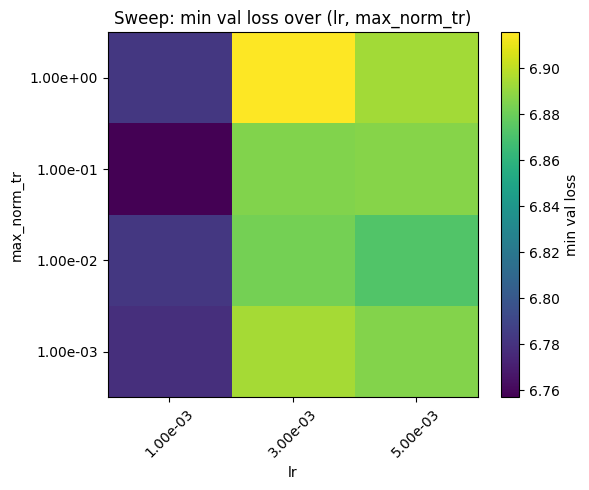

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sweep(df_in: pd.DataFrame) -> None:
    """Plot sweep metrics vs lr for different max_norm_tr values, and a 2D heatmap.

    Expects df_in to have columns:
      - lr
      - max_norm_tr
      - final_train_loss
      - min_val_loss
    """
    df_plot = df_in.dropna(subset=["lr", "max_norm_tr"]).copy()
    if df_plot.empty:
        print("No rows with both lr and max_norm_tr.")
        return

    print("Number of runs used for plots:", len(df_plot))

    # 1) Line plots: metric vs lr, colored by max_norm_tr
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

    for maxn, sub in df_plot.groupby("max_norm_tr"):
        label = f"maxnorm={maxn:g}"
        sub_sorted = sub.sort_values("lr")
        ax[0].plot(sub_sorted["lr"], sub_sorted["final_train_loss"], marker="o", label=label)
        ax[1].plot(sub_sorted["lr"], sub_sorted["min_val_loss"], marker="o", label=label)

    ax[0].set_xscale("log")
    ax[1].set_xscale("log")
    ax[0].set_xlabel("lr")
    ax[1].set_xlabel("lr")
    ax[0].set_ylabel("final train loss")
    ax[1].set_ylabel("min val loss")
    ax[0].set_title("Train loss vs lr")
    ax[1].set_title("Val loss vs lr")
    for a in ax:
        a.grid(True, which="both", ls="--", alpha=0.4)
    ax[1].legend()
    plt.tight_layout()

    # 2) 2D heatmap: min_val_loss over (lr, max_norm_tr)
    if df_plot["lr"].nunique() > 1 and df_plot["max_norm_tr"].nunique() > 1:
        pivot = df_plot.pivot_table(index="max_norm_tr", columns="lr", values="min_val_loss")
        plt.figure(figsize=(6, 5))
        im = plt.imshow(pivot.values, aspect="auto", origin="lower")
        plt.colorbar(im, label="min val loss")
        plt.xticks(range(len(pivot.columns)), [f"{x:.2e}" for x in pivot.columns], rotation=45)
        plt.yticks(range(len(pivot.index)), [f"{y:.2e}" for y in pivot.index])
        plt.xlabel("lr")
        plt.ylabel("max_norm_tr")
        plt.title("Sweep: min val loss over (lr, max_norm_tr)")
        plt.tight_layout()
    else:
        print("Not enough variation in lr/max_norm_tr for a heatmap.")

# Call the function on the loaded DataFrame
plot_sweep(df)